# Introduction

This is an electricity consumption data science and machine learning project. The goal is to find the best machine learning models that will enable us to predict and forecast with the best accuracy possible the electricity consumption knowing the temperature (database df2) and weather measurements, wind, humidity, etc (database df1). 

## Importing libraries and databases


In [18]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
import itertools as it
import statsmodels.api as sm

In [19]:
df_corkstation = pd.read_csv('df1.csv')
df_vst = pd.read_csv('df2.csv')
print(df_corkstation.columns)
df1=df_corkstation
df2=df_vst


Index(['date', 'ind', 'rain', 'ind.1', 'temp', 'ind.2', 'wetb', 'dewpt',
       'vappr', 'rhum', 'msl', 'ind.3', 'wdsp', 'ind.4', 'wddir', 'ww', 'w',
       'sun', 'vis', 'clht', 'clamt'],
      dtype='object')


## Interpolation of missing data and joining the two data sets 


### Preprocessing


Interpolating incomplsummer data from df_corkstation

In [20]:
# Changing index to date column
df_corkstation['date'] = pd.to_datetime(df_corkstation['date'])
df_corkstation.set_index('date', inplace=True)

# Interpolating over missing data
df_corkstation = df_corkstation.replace({' ': '-1'}, regex=True)
df_corkstation['wetb'] = pd.to_numeric(df_corkstation['wetb'])
df_corkstation['vis'] = pd.to_numeric(df_corkstation['vis'])
df_corkstation = df_corkstation.replace({-1: np.nan}, regex=True)
df_corkstation = df_corkstation.interpolate()

Resample and interpolating

In [21]:
# Resample for each 30 min and interpolating
df_corkstation_resampled = df_corkstation.resample('30T').interpolate(method='linear')

C:\Users\Ouarhim Younes\AppData\Local\Temp\ipykernel_46584\683809591.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_corkstation_resampled = df_corkstation.resample('30T').interpolate(method='linear')


Adding week-end, season info

In [22]:
# Lists to be used
weekend_list = []
season_list = []
work_time_list = []
year_list = []
month_list = []
day_list = []
hour_list = []
minute_list=[]
weekofyear_list = []
hours_array = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]         # 1 ... 24

# Get season function
def get_season(date):
    year = date.year
    seasons = {
        'spring': (pd.Timestamp(year=year, month=3, day=21), pd.Timestamp(year=year, month=6, day=20)),
        'summer': (pd.Timestamp(year=year, month=6, day=20), pd.Timestamp(year=year, month=9, day=20)),
        'fall': (pd.Timestamp(year=year, month=9, day=21), pd.Timestamp(year=year, month=12, day=20)),
        'winter': (pd.Timestamp(year=year, month=12, day=21), pd.Timestamp(year=year + 1, month=3, day=19))
    }

    if seasons['spring'][0] <= date <= seasons['spring'][1]:
        return 1
    elif seasons['summer'][0] <= date <= seasons['summer'][1]:
        return 2
    elif seasons['fall'][0] <= date <= seasons['fall'][1]:
        return 3
    else:
        return 4

# Adding info to lists
for date in df_corkstation_resampled.index.tolist():
    if date.weekday() == 5 or date.weekday() == 6:
        weekend_list.append(1)
    else:
        weekend_list.append(0)

    season_list.append(get_season(date))
    year_list.append(date.year)
    month_list.append(date.month)
    day_list.append(date.day)
    hour_list.append(date.hour)
    minute_list.append(date.minute)
    weekofyear_list.append(date.weekofyear)

    if date.hour >= 9 and date.hour <= 18:
        work_time_list.append(1)
    else:
        work_time_list.append(0)

    #for hour in range(1, 25):
    #    if hour == date.hour:
    #        hours_array[hour-1].append(1)
    #    else:
    #        hours_array[hour-1].append(0)

# Creating dataframes with info
weekend_df = pd.DataFrame({'weekend': weekend_list})
season_df = pd.DataFrame({'season': season_list})
work_time_df = pd.DataFrame({'work_time': work_time_list})
year_df = pd.DataFrame({'year': year_list})
month_df = pd.DataFrame({'month': month_list})
day_df = pd.DataFrame({'day': day_list})
hour_df = pd.DataFrame({'hour': hour_list})
minute_df = pd.DataFrame({'minute': minute_list})
weekofyear_df = pd.DataFrame({'weekofyear': weekofyear_list})

#hours_dfs = []
#for hour in range(1, 25):
#    hours_dfs.append(pd.DataFrame({f'hour{hour}': hours_array[hour-1]}))
#hours_df = pd.concat(hours_dfs, axis=1)

# Concating created info to the dataframe corkstation
time_info = pd.concat([weekend_df, season_df, work_time_df, year_df, month_df, day_df, hour_df, minute_df, weekofyear_df], axis=1)
time_info.set_index(df_corkstation_resampled.index, inplace=True)
df_corkstation_resampled = pd.concat([df_corkstation_resampled, time_info], axis=1)

Deleting last data from dataframes to match the consumption data

In [23]:
date_to_be_cropped = datetime.datetime(2010, 12, 14, 23, 30)
df_corkstation_cropped = df_corkstation_resampled[df_corkstation_resampled.index <= date_to_be_cropped]

df_vst['time'] = pd.to_datetime(df_vst['time'])
df_vst.set_index('time', inplace=True)
df_vst_cropped = df_vst[df_vst.index<=date_to_be_cropped]


date_to_be_cropped_ = datetime.datetime(2010,12 ,31 , 23, 30)
df_corkstation_cropped_ = df_corkstation_resampled[df_corkstation_resampled.index <= date_to_be_cropped_]

df_vst_cropped_ = df_vst[df_vst.index<=date_to_be_cropped_]





Merging two dataframes

In [24]:
df_corkstation_cropped = df_corkstation_cropped.drop(columns=['temp'])
df_corkstation_cropped_ = df_corkstation_cropped_.drop(columns=['temp'])
df_to_train_and_test = pd.concat([df_corkstation_cropped, df_vst_cropped], axis=1)
df_to_train_and_test_ = pd.concat([df_corkstation_cropped_, df_vst_cropped_], axis=1)

## Summerrmining the independent variables to use, with the AIC metric. 

In [25]:
def best_aic(df):
    y = df['mean']
    #on va retirer les variables qui ont une corrélation faible avec 'mean'
    X = df.drop(columns=['mean', 'ind.3', 'ind.4','rain','ww','w','weekend','month','minute','clamt','year','day'])
    #Ajouter cte pour ameillorer la flexibilitée du modéle
    X = sm.add_constant(X)
    selected_features = []
    remaining_features = list(X.columns)
    remaining_features.remove('const')
    #initializer les variables
    current_score, best_new_score = float('inf'), float('inf')
    #loop principale
    while remaining_features:
        scores_with_candidates = []
        for candidate in remaining_features:
            candidates = selected_features + [candidate]
            X_subset = X[candidates]
            model = sm.OLS(y, X_subset).fit()
            #calculer AIC du modéle
            score = model.aic
            scores_with_candidates.append((score, candidate))
        #classement
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]
        if current_score > best_new_score:
            remaining_features.remove(best_candidate)
            selected_features.append(best_candidate)
            current_score = best_new_score
        else:
            break 

    return selected_features

best_features = best_aic(df_to_train_and_test)
print('Best Features:'+str(best_features))

Best Features:['hour', 'season', 'work_time', 'temp', 'msl', 'wetb', 'ind', 'weekofyear', 'ind.1', 'vappr', 'wddir', 'clht', 'rhum', 'dewpt']


## Multivariable Linear regression

R^2: 0.5653254026715125
MSE: 0.03037314797696069
RMSE: 0.17427893727286922
MAPE: 23.86%


C:\Users\Ouarhim Younes\AppData\Local\Temp\ipykernel_46584\3996494574.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_data['predicted_consumption'] = winter_pred
C:\Users\Ouarhim Younes\AppData\Local\Temp\ipykernel_46584\3996494574.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer_data['predicted_consumption'] = summer_pred
C:\Users\Ouarhim Younes\AppData\Local\Temp\ipykernel_46584\3996494574.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

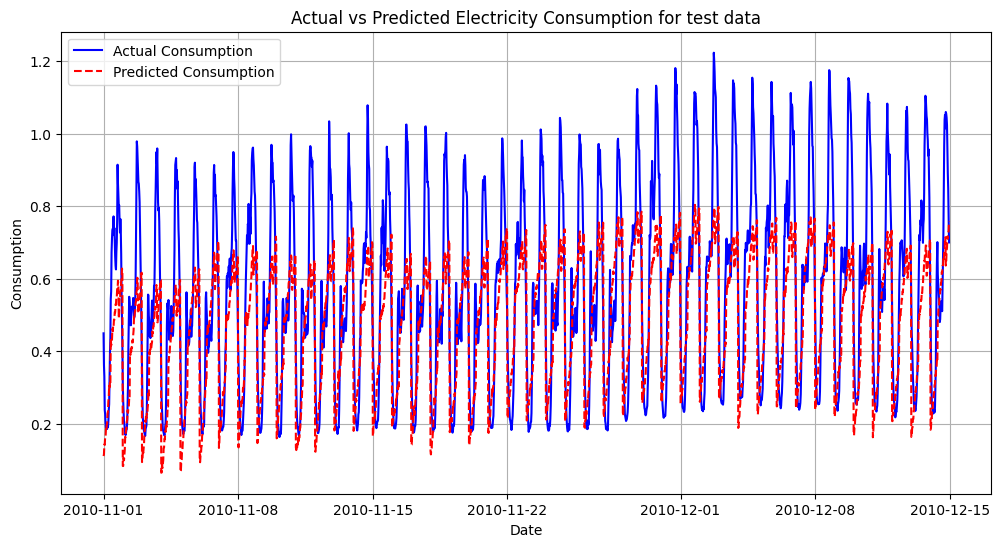

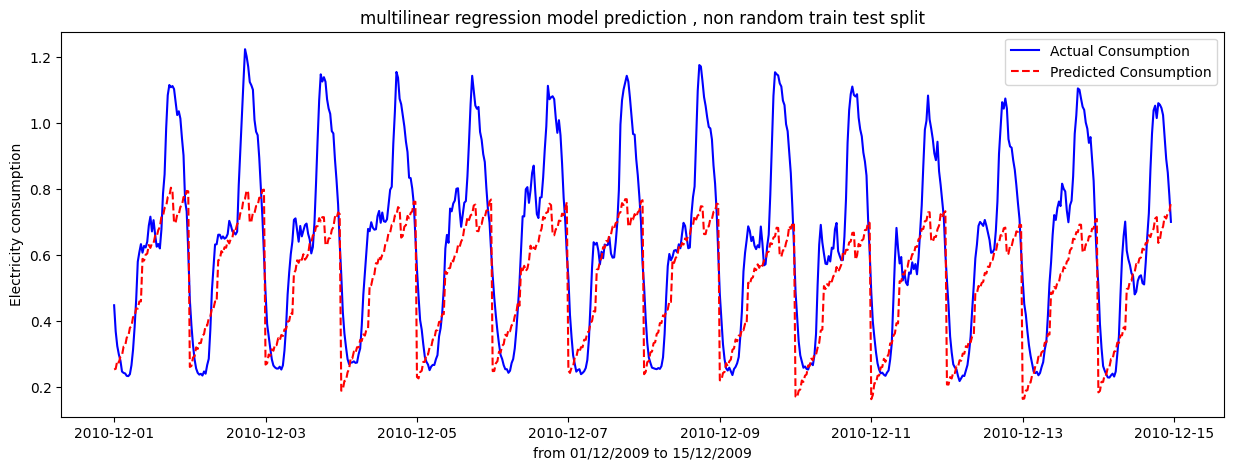

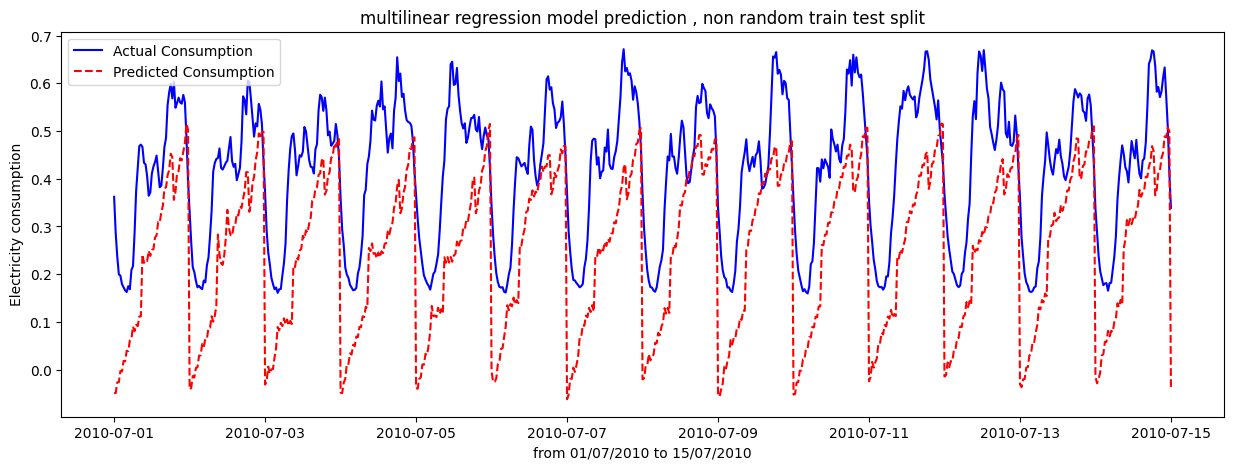

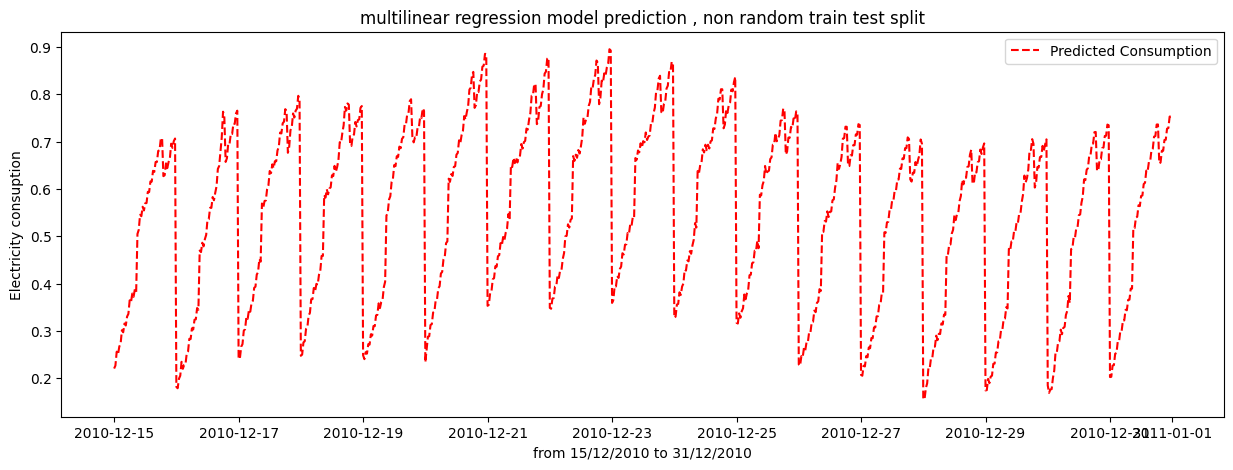

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Loading the data
df = df_to_train_and_test_
# Filtrer the data from septembre 2009 to decembre 2010
begin_date = datetime.datetime(2009, 7, 15, 0, 0)
end_date = datetime.datetime(2010, 12, 31, 23, 30)
df = df[(df.index >= begin_date) & (df.index <= end_date)][['mean' ,'hour', 'season', 'work_time', 'temp', 'msl', 'wetb', 'ind', 'weekofyear', 'ind.1', 'vappr', 'wddir', 'clht', 'rhum', 'dewpt']] # choix des paramètres

# creating a dataframe from the 15 to the 31 decembre 2010 for the electricity prediction
begin_date1 = datetime.datetime(2010, 12, 15, 0, 0)
end_date1 = datetime.datetime(2010, 12, 31, 23, 30)
future_data = df[(df.index >= begin_date1) & (df.index <= end_date1)][['mean' ,'hour', 'season', 'work_time', 'temp', 'msl', 'wetb', 'ind', 'weekofyear', 'ind.1', 'vappr', 'wddir', 'clht', 'rhum', 'dewpt']] # choix des paramètres
df = df[df.index < date_to_be_cropped]
start_time_test = pd.Timestamp('2010-11-1 00:00:00')
end_time_test = pd.Timestamp('2010-12-14 23:59:59')

start_time_winter = pd.Timestamp('2010-12-1 00:00:00')
end_time_winter = pd.Timestamp('2010-12-15 00:00:00')


start_time_summer = pd.Timestamp('2010-7-1 00:00:00')
end_time_summer = pd.Timestamp('2010-7-15 00:00:00')

# determining the winter and summer periods
summer_data = df[(df.index >= start_time_summer) & (df.index <= end_time_summer)]
winter_data = df[(df.index >= start_time_winter) & (df.index <= end_time_winter)]

# Making sure that the type of the index is DateTime for simple date manipulation
df.index = pd.to_datetime(df.index)
future_data.index = pd.to_datetime(future_data.index)



# separating the training and testing data
train_data = df[df.index < start_time_test]
test_data = df[(df.index >= start_time_test) & (df.index <= end_time_test)]
X_train = train_data.drop(columns=['mean'])
y_train = train_data['mean']
X_test = test_data.drop(columns=['mean'])
y_test = test_data['mean']
y_winter = winter_data['mean']
y_summer = summer_data['mean']


# Normalisation of the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
summer_data_scaled = scaler.transform(summer_data.drop(columns=['mean']))
winter_data_scaled = scaler.transform(winter_data.drop(columns=['mean']))
future_data_scaled = scaler.transform(future_data.drop(columns=['mean']))

# The creation and fitting of the multilinear model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# make predictions
y_pred = model.predict(X_test_scaled)
future_consumption_pred = model.predict(future_data_scaled)
winter_pred = model.predict(winter_data_scaled)
summer_pred = model.predict(summer_data_scaled)

# add the predictions future_data,winter_data et summer_data
future_data['predicted_consumption'] = future_consumption_pred
winter_data['predicted_consumption'] = winter_pred
summer_data['predicted_consumption'] = summer_pred
# Ajouter les prédictions au DataFrame test_data pour visualisation
test_data['predicted_consumption'] = y_pred


# Evaluation metrics

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R^2: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape * 100:.2f}%')

# Visualizations

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual Consumption', color='blue')
plt.plot(test_data.index, y_pred, label='Predicted Consumption', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Actual vs Predicted Electricity Consumption for test data')
plt.legend()
plt.grid(True)
plt.show()


fig, ax = plt.subplots(figsize=(15,5))
plt.plot(winter_data.index, y_winter, label='Actual Consumption', color='blue')
plt.plot(winter_data.index, winter_pred, label='Predicted Consumption', linestyle='--', color='red')
ax.legend(['real', 'prediction'], loc='upper right')
plt.title('multilinear regression model prediction , non random train test split')
plt.xlabel('from 01/12/2009 to 15/12/2009')
plt.ylabel('Electricity consumption')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(summer_data.index, y_summer, label='Actual Consumption', color='blue')
plt.plot(summer_data.index, summer_pred, label='Predicted Consumption', linestyle='--', color='red')
ax.legend(['real', 'prediction'], loc='upper right')
plt.title('multilinear regression model prediction , non random train test split')
plt.xlabel("from 01/07/2010 to 15/07/2010")
plt.ylabel('Electricity consumption')
plt.legend()
plt.show()

# Predicted electricity consumption (15 to 31 decembre 2010)

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(future_data.index, future_data['predicted_consumption'], label='Predicted Consumption', linestyle='--', color='red')
plt.title('multilinear regression model prediction , non random train test split')
ax.set_xlabel("from 15/12/2010 to 31/12/2010")
ax.set_ylabel("Electricity consuption")
plt.legend()
plt.show()



## Implementation of the LSTM (Long Short Term Memory) Neural Network
This is a neural network that allows neurons to store long-term information.
Each neuron consists of an input gate, a forget gate, and an output gate:

- The input gate decides whether the input should modify the contents of the cell;
- The forget gate decides whether the cell's contents should be reset to zero;
- The output gate decides whether the cell's contents should influence the output of the neuron.


86.49 5.98 5.6


c:\Users\Ouarhim Younes\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 1, 100)         │        55,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,701 (530.08 KB)

 Trainable params: 135,701 (530.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1344/1344 - 3s - 3ms/step - loss: 0.2724 - val_loss: 0.4473
Epoch 2/20
1344/1344 - 2s - 1ms/step - loss: 0.2383 - val_loss: 0.4312
Epoch 3/20
1344/1344 - 2s - 1ms/step - loss: 0.2337 - val_loss: 0.3609
Epoch 4/20
1344/1344 - 2s - 1ms/step - loss: 0.2303 - val_loss: 0.3563
Epoch 5/20
1344/1344 - 2s - 1ms/step - loss: 0.2283 - val_loss: 0.3419
Epoch 6/20
1344/1344 - 2s - 1ms/step - loss: 0.2270 - val_loss: 0.4051
Epoch 7/20
1344/1344 - 2s - 1ms/step - loss: 0.2265 - val_loss: 0.3483
Epoch 8/20
1344/1344 - 2s - 1ms/step - loss: 0.2245 - val_loss: 0.4273
Epoch 9/20
1344/1344 - 2s - 1ms/step - loss: 0.2239 - val_loss: 0.4325
Epoch 10/20
1344/1344 - 2s - 1ms/step - loss: 0.2239 - val_loss: 0.3651
Epoch 11/20
1344/1344 - 2s - 1ms/step - loss: 0.2220 - val_loss: 0.3664
Epoch 12/20
1344/1344 - 2s - 1ms/step - loss: 0.2211 - val_loss: 0.3978
Epoch 13/20
1344/1344 - 2s - 1ms/step - loss: 0.2210 - val_loss: 0.3699
Epoch 14/20
1344/1344 - 2s - 1ms/step - loss: 0.2198 - val_loss: 0.4016
E

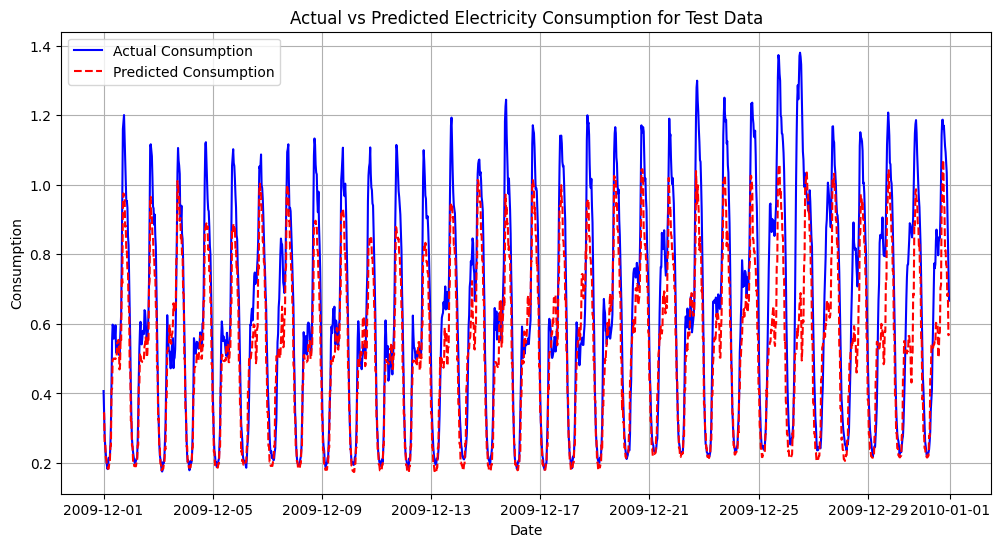

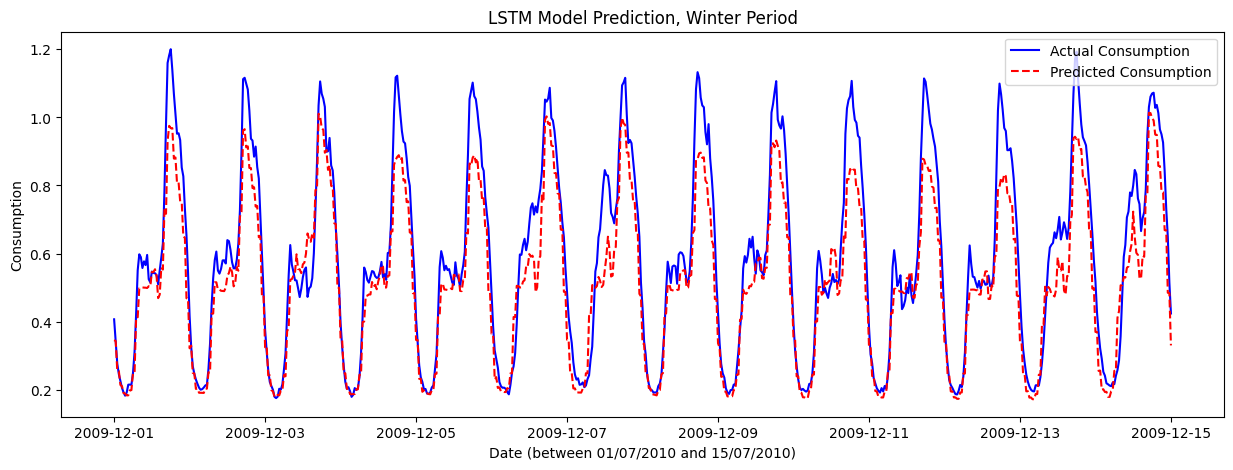

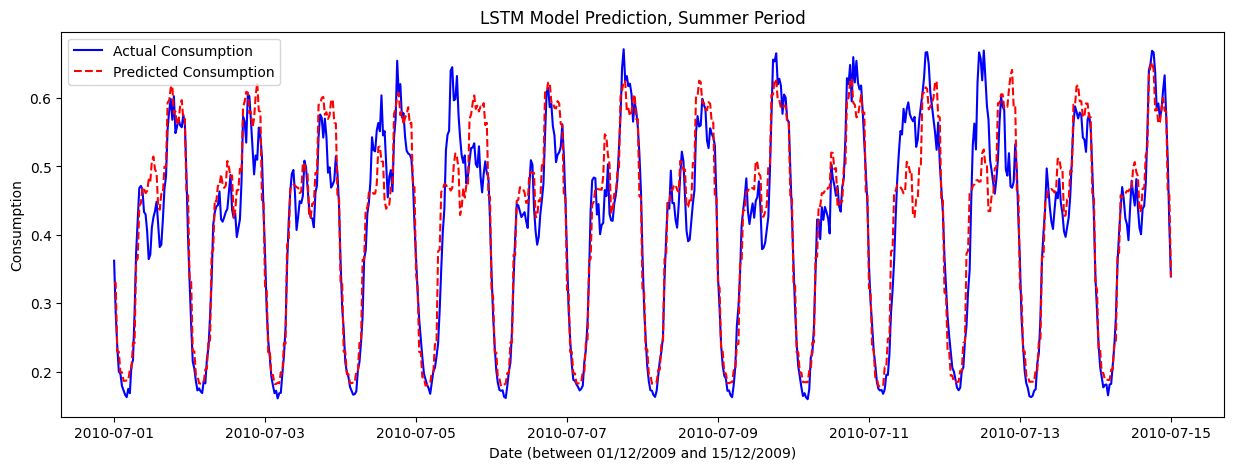

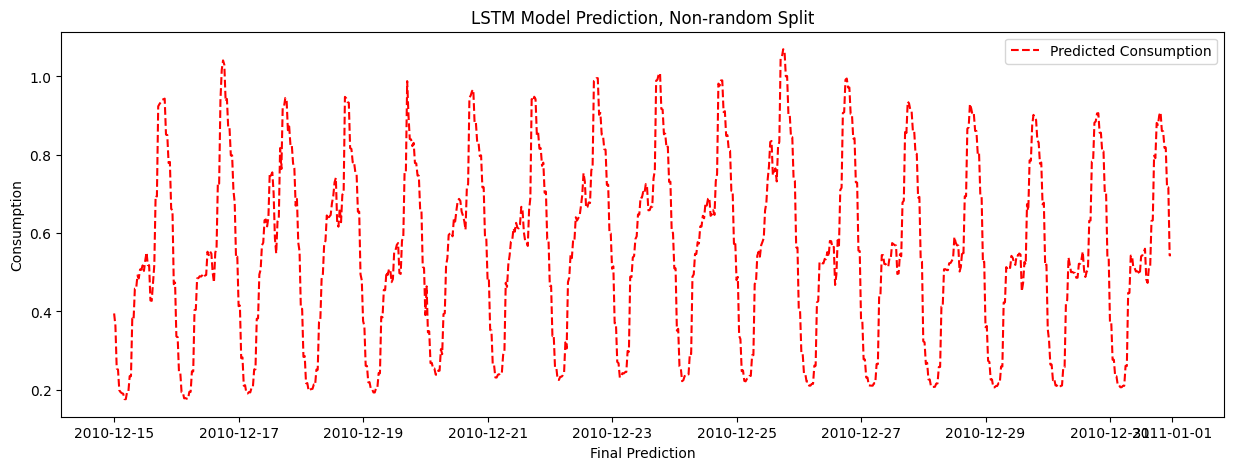

In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the data
df6 = df_to_train_and_test_.copy()
df6 = df6[['hour', 'season', 'work_time', 'temp', 'rhum', 'msl', 'ind', 'sun', 'ind.1', 'clht', 'vappr', 'dewpt', 'wddir','mean']]

# Use dummy variables for hour and season
df6 = pd.get_dummies(df6, columns=['hour', 'season'], drop_first=True)

# Define the splits
train_start_1 = datetime.datetime(2009, 7, 15, 0, 0)
train_end_1 = datetime.datetime(2009, 11, 30, 23, 30)
train_start_2 = datetime.datetime(2010, 1, 11, 0, 0)
train_end_2 = datetime.datetime(2010, 11, 15, 23, 30)
val_start = datetime.datetime(2010, 11, 16, 0, 0)
val_end = datetime.datetime(2010, 12, 14, 23, 30)
test_start = datetime.datetime(2009, 12, 1, 0, 0)
test_end = datetime.datetime(2009, 12, 31, 23, 30)
pred_start = datetime.datetime(2010, 12, 15, 0, 0)
pred_end = datetime.datetime(2010, 12, 31, 23, 30)

# Summer period
choice_start_1 = datetime.datetime(2009, 12, 1, 0, 0)
choice_end_1 = datetime.datetime(2009, 12, 15, 0)

# Winter period
choice_start_2 = datetime.datetime(2010, 7, 1, 0, 0)
choice_end_2 = datetime.datetime(2010, 7, 15, 0)

# Create the training, validation, and test sets
train_data = df6[((df6.index >= train_start_1) & (df6.index <= train_end_1)) | ((df6.index >= train_start_2) & (df6.index <= train_end_2))]
val_data = df6[(df6.index >= val_start) & (df6.index <= val_end)]
test_data = df6[(df6.index >= test_start) & (df6.index <= test_end)]

# Real data
future_data = df6[(df6.index >= pred_start) & (df6.index <= pred_end)].drop(columns=['mean'])
pred_winter = df6[(df6.index >= choice_start_1) & (df6.index <= choice_end_1)]
pred_summer = df6[(df6.index >= choice_start_2) & (df6.index <= choice_end_2)]

# Relative size of the training, test, and validation sets
print(round(train_data.shape[0]/df_to_train_and_test.shape[0] * 100,2), round(test_data.shape[0]/df_to_train_and_test.shape[0] * 100,2), round(val_data.shape[0]/df_to_train_and_test.shape[0] * 100,2))

# Restrict the dataset to the time interval where we have data
df6 = df6[df6.index < datetime.datetime(2010, 12, 15, 0, 0)]

# Split features (X) and target (y) for each set
X_train = train_data.drop(columns=['mean'])
y_train = train_data['mean']
X_val = val_data.drop(columns=['mean'])
y_val = val_data['mean']
X_test = test_data.drop(columns=['mean'])
y_test = test_data['mean']
X_choice_winter = pred_winter.drop(columns=['mean'])
y_choice_winter = pred_winter['mean']
X_choice_summer = pred_summer.drop(columns=['mean'])
y_choice_summer = pred_summer['mean']

# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)
future_data_scaled = scaler_X.transform(future_data)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
X_winter_scaled = scaler_X.transform(X_choice_winter)
y_winter_scaled = scaler_y.transform(y_choice_winter.values.reshape(-1, 1))
X_summer_scaled = scaler_X.transform(X_choice_summer)
y_summer_scaled = scaler_y.transform(y_choice_summer.values.reshape(-1, 1))

# Reshape the data for LSTM [samples, timesteps, features]
timesteps = 1
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], timesteps, X_val_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))
future_data_scaled = future_data_scaled.reshape((future_data_scaled.shape[0], timesteps, future_data_scaled.shape[1]))
X_winter_scaled = X_winter_scaled.reshape((X_winter_scaled.shape[0], timesteps, X_winter_scaled.shape[1]))
X_summer_scaled = X_summer_scaled.reshape((X_summer_scaled.shape[0], timesteps, X_summer_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(timesteps, X_train_scaled.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model with the Adam optimizer and MSE loss function
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=20, batch_size=16, validation_data=(X_val_scaled, y_val_scaled), verbose=2, shuffle=True, validation_freq=1)

# Make predictions on the sets
y_pred_scaled = model.predict(X_test_scaled)
future_pred_scaled = model.predict(future_data_scaled)
winter_pred = model.predict(X_winter_scaled)
summer_pred = model.predict(X_summer_scaled)

# Invert normalization of predictions and actual values to return to the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)
future_pred = scaler_y.inverse_transform(future_pred_scaled)
y_summer_pred = scaler_y.inverse_transform(summer_pred)
y_winter_pred = scaler_y.inverse_transform(winter_pred)

# Add predictions to the future_data DataFrame
future_data['predicted_consumption'] = future_pred
test_data['predicted_consumption'] = y_pred
test_data['actual_consumption'] = y_test
pred_winter['predicted_consumption'] = y_winter_pred
pred_summer['predicted_consumption'] = y_summer_pred

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Display performance metrics

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape * 100:.2f}%')

# Visualize results for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['actual_consumption'], label='Actual Consumption', color='blue')
plt.plot(test_data.index, test_data['predicted_consumption'], label='Predicted Consumption', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Actual vs Predicted Electricity Consumption for Test Data')
plt.legend()
plt.grid(True)
plt.show()

# Visualize results for the winter set
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(X_choice_winter.index, y_choice_winter, label='Actual Consumption', color='blue')
plt.plot(X_choice_winter.index, pred_winter['predicted_consumption'], label='Predicted Consumption', linestyle='--', color='red')
ax.legend(['Actual', 'Prediction'], loc='upper right')
plt.title('LSTM Model Prediction, Winter Period')
plt.xlabel("Date (between 01/07/2010 and 15/07/2010)")
plt.ylabel('Consumption')
plt.legend()
plt.show()

# Visualize results for the summer set
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(X_choice_summer.index, y_choice_summer, label='Actual Consumption', color='blue')
plt.plot(X_choice_summer.index, pred_summer['predicted_consumption'], label='Predicted Consumption', linestyle='--', color='red')
ax.legend(['Actual', 'Prediction'], loc='upper right')
plt.title('LSTM Model Prediction, Summer Period')
plt.xlabel('Date (between 01/12/2009 and 15/12/2009)')
plt.ylabel('Consumption')
plt.legend()
plt.show()

# Visualize results for the prediction period (December 15 to December 31, 2010)
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(future_data.index, future_data['predicted_consumption'], label='Predicted Consumption', linestyle='--', color='red')
plt.title('LSTM Model Prediction, Non-random Split')
ax.set_xlabel("Final Prediction")
ax.set_ylabel("Consumption")
plt.legend()
plt.show()




### Random Forest

MAPE Test Data = 7.591%
MAPE End of December 2009 = 3.767%
MAPE Hard Test Data = 11.127%
MAPE Hard End of December 2009 = 6.853%


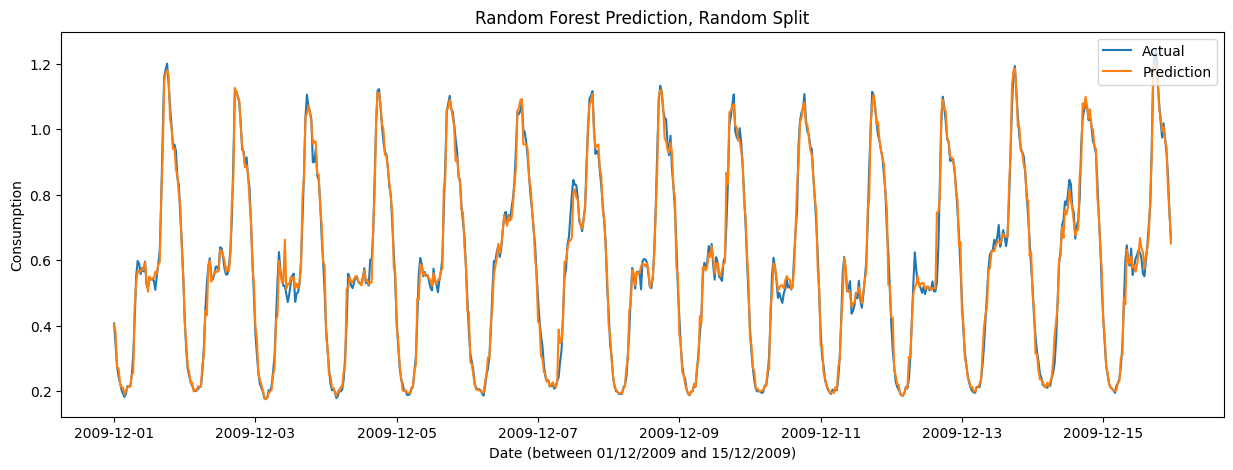

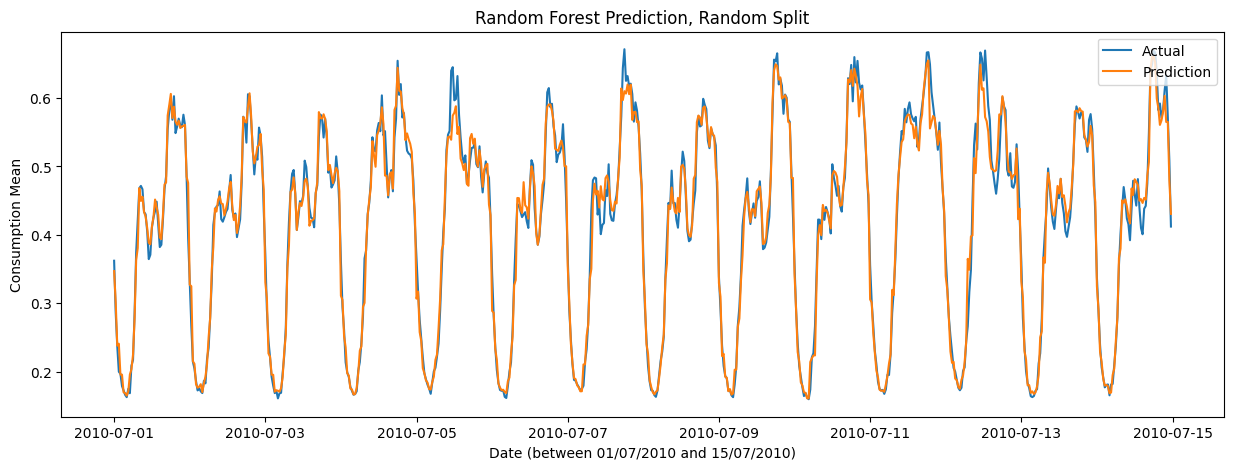

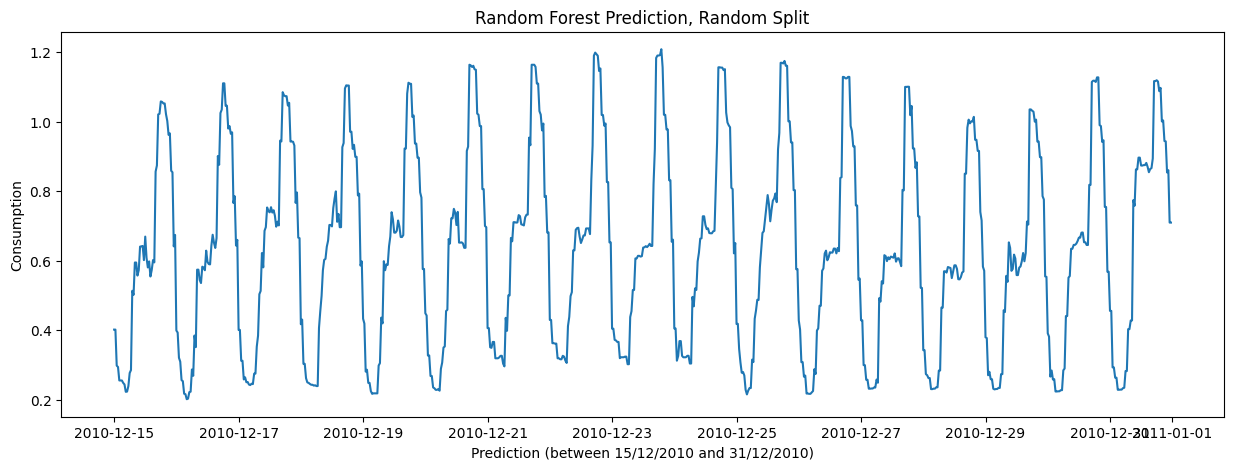

In [34]:
# Variables selected using AIC
variables = ['hour', 'season', 'work_time', 'temp', 'rhum', 'msl', 'ind', 'weekofyear', 'sun', 'ind.1', 'clht', 'vappr', 'dewpt', 'wddir']

# Data split randomly and temporally. 'Hard' data for temporal split
x_train, x_test, y_train, y_test = train_test_split(df_to_train_and_test[variables], df_to_train_and_test['mean'], test_size=0.2, random_state=42)
x_train_hard, x_test_hard, y_train_hard, y_test_hard = train_test_split(df_to_train_and_test[variables], df_to_train_and_test['mean'], test_size=0.2, random_state=42, shuffle=False)

regr = RandomForestRegressor(n_jobs=-1)

# Hyperparameter search. Commented due to long execution time

# Hyperparameter search. Random split
'''
paramsummerrs_ranodmizedSearch = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [None, 10, 50, 100],
    'n_estimators': [10, 50, 100],
    'max_features': [None, 'sqrt']
}

clf_randomSearch = RandomizedSearchCV(regr, paramsummerrs_ranodmizedSearch, scoring='neg_mean_absolute_percentage_error', random_state=0, n_jobs=-1)
clf_randomSearch.fit(x_train, y_train)

results_randomSearch = pd.DataFrame(clf_randomSearch.cv_results_)
results_randomSearch = results_randomSearch.sort_values(by=['rank_test_score'])
results_randomSearch = results_randomSearch[['mean_fit_time', 'param_n_estimators', 'param_max_features', 'param_max_depth', 'param_criterion', 'mean_test_score','rank_test_score']]

results_randomSearch.head()

paramsummerrs_ranodmizedSearch = {
    'criterion': ['poisson'],
    'max_depth': [None],
    'n_estimators': [5, 10, 50, 100],
    'max_features': [None]
}

clf_randomSearch = GridSearchCV(regr, paramsummerrs_ranodmizedSearch, scoring='neg_mean_absolute_percentage_error', random_state=0, n_jobs=-1)
clf_randomSearch.fit(x_train, y_train)

results_gridSearch = pd.DataFrame(results_gridSearch.cv_results_)
results_gridSearch = results_gridSearch.sort_values(by=['rank_test_score'])
results_gridSearch = results_gridSearch[['mean_fit_time', 'param_n_estimators', 'param_max_features', 'param_max_depth', 'param_criterion', 'mean_test_score','rank_test_score']]

results_gridSearch.head()
'''
# Hyperparameter search. Temporal split
'''
tscv = TimeSeriesSplit(n_splits=5)
clf_randomSearch = RandomizedSearchCV(regr, paramsummerrs_ranodmizedSearch, scoring='neg_mean_absolute_percentage_error', random_state=0, n_jobs=-1, cv = tscv)
clf_randomSearch.fit(x_train_hard, y_train_hard)
'''

# Optimal regressor
regr_optimal = RandomForestRegressor(criterion='poisson', max_depth=None, max_features=None, n_estimators=10, random_state=0)
regr_optimal.fit(x_train, y_train)

# Hard data regressor
regr_optimal_hard = RandomForestRegressor(criterion='squared_error', max_depth=10, max_features=None, n_estimators=50, random_state=0)
regr_optimal_hard.fit(x_train_hard, y_train_hard)

# Plot some predictions
date_to_be_cropped_begin = datetime.datetime(2009, 12, 1, 0, 0)
date_to_be_cropped_end = datetime.datetime(2009, 12, 15, 23, 30)
data_end_december_2009 = df_to_train_and_test[df_to_train_and_test.index >= date_to_be_cropped_begin]
data_end_december_2009 = data_end_december_2009[data_end_december_2009.index < date_to_be_cropped_end]
y_end_december_2009 = data_end_december_2009['mean']
x_end_december_2009 = data_end_december_2009[variables]
y_predicted_end_december_2009 = regr_optimal.predict(x_end_december_2009)

date_to_be_cropped_begin = datetime.datetime(2010, 7, 1, 0, 0)
date_to_be_cropped_end = datetime.datetime(2010, 7, 15, 0, 0)
data_begin_july_2010 = df_to_train_and_test[df_to_train_and_test.index >= date_to_be_cropped_begin]
data_begin_july_2010 = data_begin_july_2010[data_begin_july_2010.index < date_to_be_cropped_end]
y_begin_july_2010 = data_begin_july_2010['mean']
x_begin_july_2010 = data_begin_july_2010[variables]
y_predicted_begin_july_2010 = regr_optimal.predict(x_begin_july_2010[variables])

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(x_end_december_2009.index, y_end_december_2009)
plt.plot(x_end_december_2009.index, y_predicted_end_december_2009)
plt.title('Random Forest Prediction, Random Split')
ax.legend(['Actual', 'Prediction'], loc='upper right')
ax.set_xlabel("Date (between 01/12/2009 and 15/12/2009)")
ax.set_ylabel("Consumption")

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(x_begin_july_2010.index, y_begin_july_2010)
plt.plot(x_begin_july_2010.index, y_predicted_begin_july_2010)
plt.title('Random Forest Prediction, Random Split')
ax.legend(['Actual', 'Prediction'], loc='upper right')
ax.set_xlabel("Date (between 01/07/2010 and 15/07/2010)")
ax.set_ylabel("Consumption Mean")

# MAPE
y_test_predicted = regr_optimal.predict(x_test)
mape_test_data = mean_absolute_percentage_error(y_test, y_test_predicted) * 100
mape_end_december_2009 = mean_absolute_percentage_error(y_predicted_end_december_2009, y_end_december_2009) * 100

print("MAPE Test Data = " + str(round(mape_test_data, 3)) + "%")
print("MAPE End of December 2009 = " + str(round(mape_end_december_2009, 3)) + "%")

# MAPE Hard Data
y_predicted_end_december_2009 = regr_optimal_hard.predict(x_end_december_2009)
y_hard_test_predicted = regr_optimal_hard.predict(x_test_hard)
mape_test_data = mean_absolute_percentage_error(y_test_hard, y_hard_test_predicted) * 100
mape_end_december_2009 = mean_absolute_percentage_error(y_predicted_end_december_2009, y_end_december_2009) * 100

print("MAPE Hard Test Data = " + str(round(mape_test_data, 3)) + "%")
print("MAPE Hard End of December 2009 = " + str(round(mape_end_december_2009, 3)) + "%")

# Requested Prediction
data_begin_prediction = datetime.datetime(2010, 12, 15, 0, 0)
data_end_prediction = datetime.datetime(2010, 12, 31, 23, 30)

future_data = df_corkstation_resampled[(df_corkstation_resampled.index >= data_begin_prediction) & (df_corkstation_resampled.index <= data_end_prediction)]

final_prediction = regr_optimal.predict(future_data[variables])

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(future_data.index, final_prediction)
plt.title('Random Forest Prediction, Random Split')
ax.set_xlabel("Prediction (between 15/12/2010 and 31/12/2010)")
ax.set_ylabel("Consumption")

mean = pd.DataFrame(final_prediction)
mean = mean.set_index(future_data.index)
mean = mean.rename(columns={0: 'mean'})
temp = future_data['temp']

df_prediction = pd.concat([mean, temp], axis=1)
df_prediction.index.names = ['time']

date_to_be_cropped = datetime.datetime(2010, 12, 14, 23, 30)
other_vst = df_vst[df_vst.index <= date_to_be_cropped]

df_to_export = pd.concat([other_vst, df_prediction], axis=0)
df_to_export.to_csv('df_vst_group_6_.csv')



# Conclusion 

We set out to develop the best possible model for predicting electricity consumption, and we succeeded in finding a highly accurate model: the random forest model, which achieved a MAPE of 7.591%. This is significantly lower than the MAPE scores of the LSTM machine learning model (15.39%) and the multilinear regression model (23.86%), highlighting its superior performance on the test data.

In future work, we could further refine our predictions by exploring other advanced forecasting techniques, such as the SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Variables) model or the XGBoost model, both of which hold promise for improving accuracy.

Finally, I want to express my gratitude to my team for their outstanding contributions to this project. Their dedication and collaboration made this success possible.